## Step 1: Import Libraries


In [26]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Step 2: Load the Dataset


In [27]:
file_path = "DDos.pcap_ISCX.csv"
df = pd.read_csv(file_path)

## Step 3: Data Inspection


In [28]:
print("Dataset Information:")
print(df.info())
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean

c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


        Destination Port   Flow Duration   Total Fwd Packets  \
count       225745.00000    2.257450e+05       225745.000000   
mean          8879.61946    1.624165e+07            4.874916   
std          19754.64740    3.152437e+07           15.422874   
min              0.00000   -1.000000e+00            1.000000   
25%             80.00000    7.118000e+04            2.000000   
50%             80.00000    1.452333e+06            3.000000   
75%             80.00000    8.805237e+06            5.000000   
max          65532.00000    1.199999e+08         1932.000000   

        Total Backward Packets  Total Length of Fwd Packets  \
count            225745.000000                225745.000000   
mean                  4.572775                   939.463346   
std                  21.755356                  3249.403484   
min                   0.000000                     0.000000   
25%                   1.000000                    26.000000   
50%                   4.000000               

## Step 4: Data Preprocessing


In [29]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Alternatively, drop rows with NaN values
df.dropna(inplace=True)

## Step 5: Handle Class Imbalance


In [30]:
# Map the labels to numeric values
df['Label'] = df['Label'].map({'DDoS': 1, 'BENIGN': 0})

# Check the class distribution again
print("Class distribution before balancing:")
print(df['Label'].value_counts())

# Handle class imbalance
majority_class = df[df['Label'] == 0]
minority_class = df[df['Label'] == 1]

# Check for empty classes
if majority_class.empty or minority_class.empty:
    raise ValueError("One of the classes is empty. Check the dataset or the 'Label' column.")

# Resampling
minority_oversampled = resample(
    minority_class,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class),  # Match majority class size
    random_state=42  # Reproducible results
)

# Combine the majority class and the oversampled minority class
df_balanced = pd.concat([majority_class, minority_oversampled])

print("Class distribution after balancing:")
print(df_balanced['Label'].value_counts())

Class distribution before balancing:
Label
1    128025
0     97686
Name: count, dtype: int64
Class distribution after balancing:
Label
0    97686
1    97686
Name: count, dtype: int64


## Step 6: Split the Dataset


In [31]:
# Splitting features and labels
X = df_balanced.drop('Label', axis=1)
y = df_balanced['Label']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Step 7: Exploratory Data Analysis



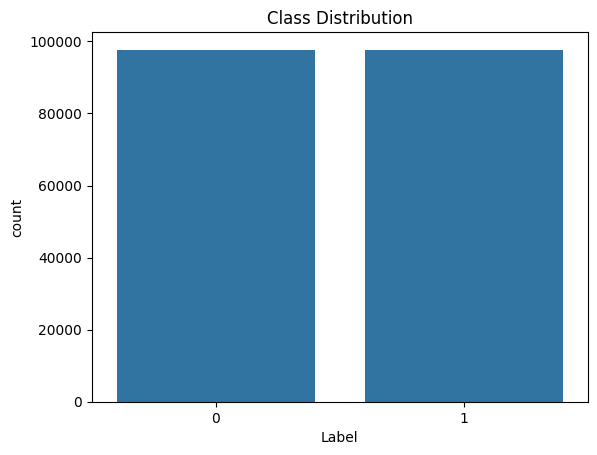

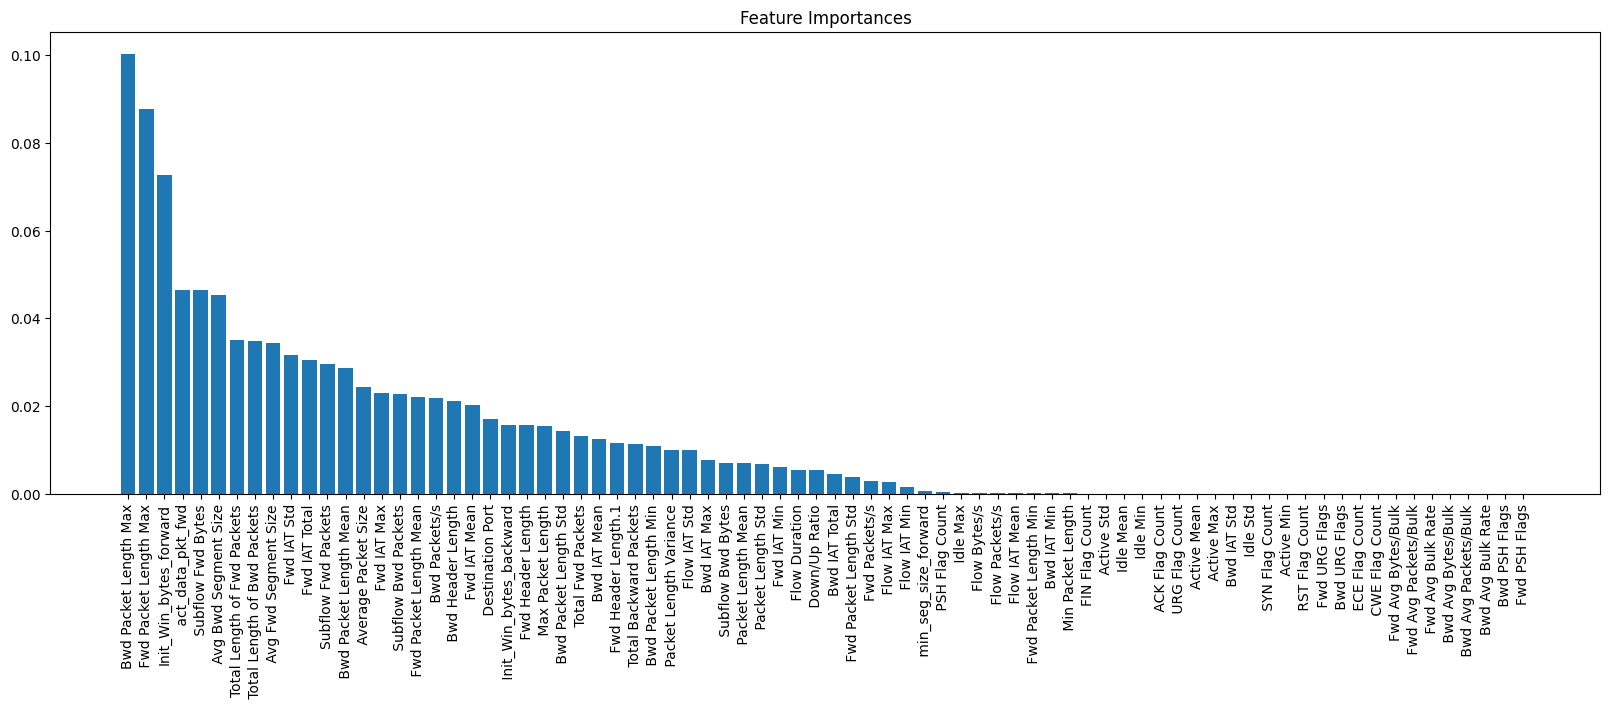

Selected features:
Index(['Bwd Packet Length Max', ' Fwd Packet Length Max',
       'Init_Win_bytes_forward', ' act_data_pkt_fwd', ' Subflow Fwd Bytes'],
      dtype='object')


In [32]:
# EDA - Visualizing the distribution of classes
sns.countplot(x='Label', data=df_balanced)
plt.title('Class Distribution')
plt.show()

# Feature Selection - Using Random Forest Importance
rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting feature importance
plt.figure(figsize=(20, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

# Selecting the top N features
N = 5
X_train_selected = X_train.iloc[:, indices[:N]]
X_test_selected = X_test.iloc[:, indices[:N]]

# Print selected features
selected_features = X.columns[indices[:N]]  # Extract feature names using indices
print("Selected features:")
print(selected_features)

# Adding noise factor
noise_factor = 0.05
X_train_selected = X_train_selected + noise_factor * np.random.normal(size=X_train_selected.shape)
X_test_selected = X_test_selected + noise_factor * np.random.normal(size=X_test_selected.shape)


In [33]:
noise_factor = 0.05
X_train_selected = X_train_selected + noise_factor * np.random.normal(size=X_train_selected.shape)
X_test_selected = X_test_selected + noise_factor * np.random.normal(size=X_test_selected.shape)

## Step 8: Model Training and Evaluation


In [34]:
# Model Training and Evaluation
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=5, n_estimators=50, random_state=42)
}

results = {}
best_model = None
best_accuracy = 0

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Check for the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Print the best model and its accuracy
print(f"Best Model: {best_model}")
print(f"Best Model Accuracy: {best_accuracy:.4f}")

Decision Tree Accuracy: 0.9991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29182
           1       1.00      1.00      1.00     29430

    accuracy                           1.00     58612
   macro avg       1.00      1.00      1.00     58612
weighted avg       1.00      1.00      1.00     58612

Random Forest Accuracy: 0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29182
           1       1.00      1.00      1.00     29430

    accuracy                           1.00     58612
   macro avg       1.00      1.00      1.00     58612
weighted avg       1.00      1.00      1.00     58612

Extra Trees Accuracy: 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29182
           1       1.00      1.00      1.00     29430

    accuracy                           1.00     58612
   macro avg       1.00      1.00    

c:\Users\hit k\anaconda3\envs\bia\lib\site-packages\xgboost\core.py:158: UserWarning: [10:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Step 9: Visualize Results (Optional)


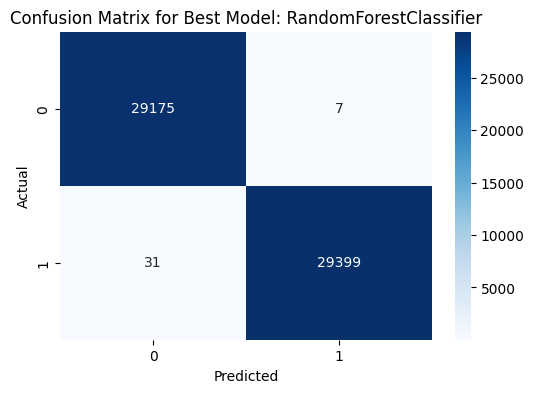

Precision: 0.9997619533428552
Recall: 0.9989466530750934
F1 Score: 0.9993541369229724


['Classifying_Network_Traffic_Flow.pkl']

In [35]:
# Confusion Matrix for the best model
y_pred_best = best_model.predict(X_test_selected)
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for Best Model: {best_model.__class__.__name__}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

from sklearn.metrics import f1_score, precision_score, recall_score

y_pred_best = best_model.predict(X_test_selected)
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))

# Save the trained model
joblib.dump(best_model, "Classifying_Network_Traffic_Flow.pkl")

In [36]:
# Save the trained model
joblib.dump(best_model, "Classifying_Network_Traffic_Flow.pkl")

['Classifying_Network_Traffic_Flow.pkl']